<div align="right" style="text-align: right"><i>Peter Norvig<br>August 2021</i></div>

# RaceTrack

From 538's [The Riddler](https://fivethirtyeight.com/features/can-you-zoom-around-the-race-track/) on 6 August 2021 (slightly edited):

> The game of [RaceTrack](https://link.springer.com/chapter/10.1007/978-3-642-13122-6_26) was published by recreational mathematician [Martin Gardner](http://www.martin-gardner.org/) in [1973](https://www.scientificamerican.com/article/mathematical-games-1973-01/). There have been some neat [digital versions](https://harmmade.com/vectorracer/#) since then, and it’s high time we had a race here: the Riddler-opolis 500!
>
> You begin at the blue point on the starting line below the circle (diagram shown below) with a velocity vector of zero, and your goal is to circumnavigate the track in a counterclockwise loop. You’ll be moving in straight line segments from point to point on the grid, without ever crashing into the outer wall or the central circle.  (Moving tangent to the circle is allowed, as is being on a grid point along a wall.)
>
> For each move you have a choice of nine possible destinations, corresponding to the 3x3 grid that surrounds the point formed by adding your current velocity vector to your current position. That is, you can maintain your current velocity, or you can alter your velocity (and hence your destination) by accelerating one grid point in any direction (horizontally, vertically or diagonally). For example, if your first move was up and to the right, then your nine possible second moves are shown below, although two of them will cause you to crash into the central circle and one of them is standing still.
>
> ![](https://fivethirtyeight.com/wp-content/uploads/2021/08/Screen-Shot-2021-08-04-at-10.44.11-PM.png?w=400)
>
> How quickly can you navigate the track? 
>


# Defining Points and Vectors

We will need to represent 2-D points on a grid, as well as 2-D vectors for velocity and acceleration. I will use the following choices:
- `Point(x, y)`: a point in the 2-D plane, implemented as a complex number.
- `Vector(x, y)`: a vector in the 2-D plane, also implemented as a complex number.
- `Path`: a list of points (representing the car's positions as it moves).
- `X(point)`, `Y(point)`: the x- and y-coordinates of a point, respectively.
- `zero`: a zero vector (the car's starting velocity vector).
- `accelerations`: the nine possible acceleration vectors (to change the car's velocity), mapped to the digit number that The Riddler uses to identify them.


In [1]:
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict, Set

Point = Vector = complex
Path  = List[Point]

def X(point) -> float: "x-coordinate"; return point.real
def Y(point) -> float: "y-coordinate"; return point.imag

zero = Vector(0, 0)

accelerations = {Vector(-1, 1): 1, Vector(0, 1): 2, Vector(1, 1): 3, 
                 Vector(-1, 0): 4, Vector(0, 0): 5, Vector(1, 0): 6, 
                 Vector(-1, -1):7, Vector(0, -1):8, Vector(1, -1):9}

# Defining the Track

I want to solve the particular problem posed by The Riddler, but I also want some flexibility to race on differently-shaped race tracks. I'll define the class `Track` as a subclass of a `set` (of `Point`s), with some additional attributes:
- `track.start`: the single starting point.
- `track.finish`: the two endpoints of the finish line.
- `track.radius`: the radius of the central circle (whose center is defined as the origin).

The points in the track are all those points on a 15x15 square except the ones that fall inside the circle's radius.


In [2]:
class Track(Set):
    def __init__(self, items, **kwds):
        self.update(items)
        self.__dict__.update(kwds)

radius = 3
track  = Track({Point(x, y) for x in range(-7, 8) for y in range(-7, 8) 
                if abs(Point(x, y)) >= radius}, 
               start=Point(0, -5), 
               finish=[Point(0, -3), Point(0, -7)], 
               radius=radius)

# Visualization

I think it will be helpful to be able to visualize paths on the track, so I'll define a function to do that now, even before attempting to find solutions:

In [3]:
def plot(paths=(), track=track):
    """Plot the track and any paths, along with the start and finish line."""
    fig, ax = plt.subplots()
    plt.xticks([]); plt.yticks([])
    ax.set_aspect('equal')
    ax.add_artist(plt.Circle((0, 0), track.radius, alpha=1/3, color='k', ec='w'))
    ax.plot(*XY(track), 'k,' )          # grid points
    ax.plot(*XY([track.start]), 'ks', ms=10)  # start point
    ax.plot(*XY(track.finish), 'k:')          # finish line
    for path in paths:                  # paths
        ax.plot(*XY(path), 'o-')  
    plt.title(f'{len(paths)} paths of {set(len(path) - 1 for path in paths)} moves')
    
def XY(points) -> Tuple[List[float], List[float]]: 
    """A tuple of: (the x-coordinates of points, the y-coordinates of points)."""
    return [X(p) for p in points], [Y(p) for p in points]

Below is my recreation of The Riddler's diagram of the first two moves. Here and throughout I'll use the convention:
- `p` is a point indicating a move
- `p1` is where the next point would be if the velocity remains constant.
- `p2` is where the next point actually is with acceleration applied to change the velocity.

In this example, `p` is up and right from the start to `Point(1, -4)`, so the velocity is  `Vector(1, 1)`.

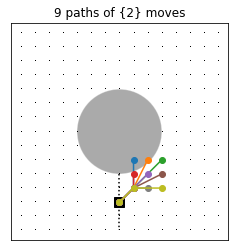

In [4]:
p   = Point(1, -4)
p1  = p + Vector(1, 1)
p2s = [p1 + a for a in accelerations]

plot([[track.start, p, p2] for p2 in p2s])

# Circumnavigating the Track

The goal of the race is to circumnavigate the center circle. I can test if a path goes from the fourth [quadrant](https://mathworld.wolfram.com/Quadrant.html) to the first, second, third, and back to the fourth. The predicate `is_solution(path)` does that.

<center><div><img src="https://upload.wikimedia.org/wikipedia/commons/thumb/e/e3/Cartesian-coordinate-system-with-quadrant.svg/242px-Cartesian-coordinate-system-with-quadrant.svg.png" width=120></div></center>


If you wanted to generalize this to other race tracks, you could change the definition of `quadrant` (there could be more than 4 "quadrants," and they could have any shape), and change the `goals` in `is_solution`.

In [5]:
def is_solution(path, goals=(4, 1, 2, 3, 4)) -> bool:
    """Does the path go through all the goal quadrants in the prescribed order?"""
    i = 0 # Index of next goal to be achieved
    for p in path:
        if quadrant(p) == goals[i]:
            i += 1 # Start looking for the next goal
            if i == len(goals):
                return True
    return False

def quadrant(p: Point) -> int: 
    """What quadrant of the 2-D plane is this point in?"""
    return (1 if Y(p) >= 0 else 4) if X(p) >= 0 else (2 if Y(p) >= 0 else 3)

# Legal Moves

As stated earlier, I want to solve the specific circular track, and also make the code general enough that it can handle other tracks. I'll do that by splitting up responsibility for determining legal moves:
- `all_moves(path)` is general; it returns the points on the track that can be reached by applying  the 9 accelerations.
- `circular_track_moves(path)` is specific; it limits moves in the following ways:
  - It won't make moves that stay in one place (they are legal, but wasteful and not needed on this track).
  - It won't pass from the fourth quadrant backwards over the finish line into the third (legal, but wasteful).
  - It won't let a move's line segment intersect the central circle (even if the start and end points of the move are on valid grid points outside of the circle).


In [6]:
def all_moves(path, track=track) -> Set[Point]:
    """Moves with any allowable acceleration that end up on the track."""
    p1 = path[-1] + velocity(path)
    return {(p1 + a) for a in accelerations} & track
                
def circular_track_moves(path, track=track) -> Set[Point]:
    """Reasonable moves on the circular track."""
    p = path[-1]
    return {p2 for p2 in all_moves(path, track)
            if p2 != p
            and not (quadrant(p) == 4 and quadrant(p2) == 3) # Don't go backwards
            and not intersects_circle(p, p2, track)}

def velocity(path) -> Vector:
    """Velocity of the car when it is at the end of the path."""
    return zero if len(path) == 1 else path[-1] - path[-2]  

The math for solving for the intersection of a line segment and a circle  [looks complicated](https://stackoverflow.com/questions/6091728/line-segment-circle-intersection), so instead I just define N+1 points along the line from point *p* to point *p2* and check if any of those points is within the radius of the circle (which by definition is centered on the origin). If N is too small this could miss an intersection, but that shouldn't be a problem for our uses.

In [7]:
def intersects_circle(p: Point, p2: Point, track=track) -> bool:
    """Does any point w on the line from p to p2 fall within radius of center?"""
    return any(abs(w) < track.radius for w in waypoints(p, p2))

def waypoints(p, p2, N=20) -> List[Point]:
    """All the points that are i/N of the way from p to p2"""
    return [p + (i / N) * (p2 - p)
            for i in range(N + 1)]

# A Frontier of Possible Paths

Now I want to expand paths by adding legal moves to the end until I find solution(s)–paths that circumnavigate the circle. I could keep all my paths in a `list`, but there will be an exponential number of them (up to 9<sup><i>n<i/></sup> paths of length *n* and I estimate *n* will be around 10 to 13).

Instead I will keep track of a *frontier*, which I define as a mapping of `{(endpoint, velocity): path}`. The idea is that there may be many paths that arrive at the some endpoint with the same velocity in the same number of moves. I only need to keep one of them, because they can all be continued in exactly the same ways.
    
*Note:* Before I added the limitation that moves can't pass backwards from the fourth quadrant to the third, I had **a bug**: sometimes the frontier would capture a `(endpoint, velocity)` pair for a path that was in the third quadrant but hadn't circumnavigated, and was replacing a path to the same point that had circumnavigated. That meant I was discarding some valid paths.

In [8]:
Frontier = Dict[Tuple[Point, Vector], Path]

def expand(frontier, legal_moves=circular_track_moves, track=track) -> Frontier:
    """The {(endpoint, velocity): path} frontier extended one move in all legal ways."""
    return {(p, velocity([path[-1], p])): path + [p] 
            for path in frontier.values() 
            for p in legal_moves(path, track)}

# Searching for the Fastest Solutions

Now all I have to do to solve the problem is repeatedly expand the frontier until one or more solutions are found. The first solutions found are guaranteed to be the fastest (i.e., they are the paths with the fewest possible moves), because we are expanding paths one move at a time, and the previous time did not find any solutions. In the end, I return a list of all the solutions in the frontier, but there may be many other paths that are not returned, because the frontier only keeps one path for each `(endpoint, velocity)` pair, and there are only so many ways to cross the finish line. 

In [9]:
def search(track=track, path=None, legal_moves=circular_track_moves) -> List[Path]:
    """Find the shortest possible solution paths."""
    if path is None: path = [track.start]
    frontier = {(path[-1], velocity(path)): path}
    solutions = []
    while not solutions:
        frontier  = expand(frontier, legal_moves, track)
        solutions = list(filter(is_solution, frontier.values()))
    return solutions

# Solutions!

We are ready to solve the problem:

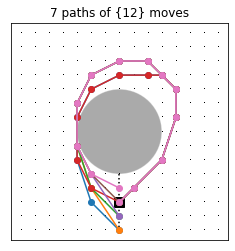

In [10]:
solutions = search(track)

plot(solutions)

We see that the fastest solution is 12 moves, and there are at least 7 ways to get there (with perhaps other ways discarded).

# Submitting your Answer

I'll need a bit of "tricky work" to put my answers into the form requested by The Riddler:

> Finally, submitting your answer can be tricky work. Please be sure to submit both your total time, as well as your sequence of moves. Each move should be assigned a digit from 1 through 9, corresponding to the nine possible destinations of the move:
>
>     1 2 3
>     4 5 6
>     7 8 9

I will define two functions to translate back and forth between my `Path` and The Riddler's list of `Digits`: 

In [11]:
Digits = List[int] # each int is 1-9

def digits_from_path(path) -> Digits:
    """The digits that the path represents."""
    return [accelerations[velocity(path[:i + 1]) - velocity(path[:i])]
            for i in range(1, len(path))]

def path_from_digits(digits, start=track.start) -> Path:
    """The path that the digits represent."""
    v = zero # Starting velocity
    path = [start]
    for d in digits:
        v += next(a for a in accelerations if accelerations[a] == d)
        path.append(v + path[-1])
    return path

In [12]:
[digits_from_path(path) for path in solutions]

[[3, 3, 1, 7, 7, 8, 4, 8, 9, 9, 6, 3],
 [3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 6, 6],
 [3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 6, 3],
 [3, 3, 1, 7, 7, 8, 4, 8, 9, 9, 3, 3],
 [3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 3, 9],
 [3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 3, 6],
 [3, 3, 1, 7, 7, 5, 7, 8, 9, 9, 3, 3]]

# Alternative Solutions

I have identified six different opening sequences of moves that each lead to solutions with the fastest possible time of 12 moves. I don't understand why every plot has exactly 7 solution paths; I suppose it is just because the finish line is crowded and there are only so many ways to get there.

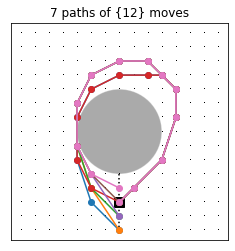

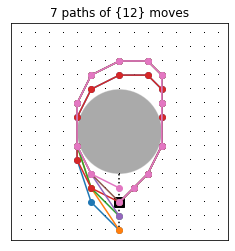

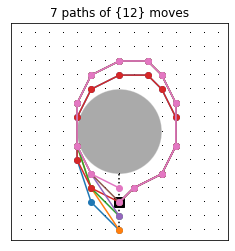

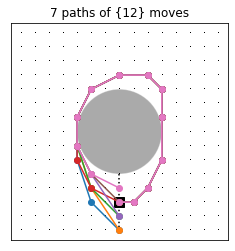

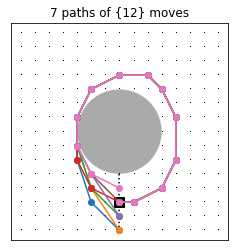

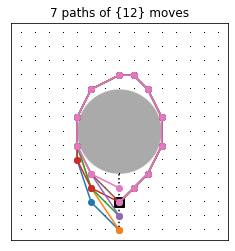

In [13]:
openings = [3, 3], [3, 5], [3, 6], [6, 2], [6, 3], [3, 5, 2, 4, 4]

for digits in openings:
    plot(search(track, path=path_from_digits(digits)))

# Visualizations and Tests

To gain more confidence in the code, here are some visualizations and unit tests:

In [14]:
def test_intersects(expected: bool, segments: List[Path]):
    """Test if [p, q] segments get the expected result from `intersects_circle`."""
    plot(segments)
    for p, q in segments:
        assert intersects_circle(p, q) is expected

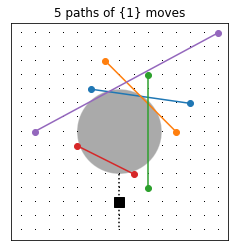

In [15]:
test_intersects(True, [ # Line segments that intersect the circle
    [Point(-2, 3), Point(5, 2)], 
    [Point(-1, 5), Point(4, 0)], 
    [Point(2, 4),  Point(2, -4)],
    [Point(-3, -1),Point(1, -3)],
    [Point(-6, 0), Point(7, 7)]])

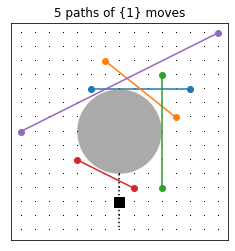

In [16]:
test_intersects(False, [ # Line segments that do not intersect the circle
    [Point(-2, 3), Point(5, 3)], 
    [Point(-1, 5), Point(4, 1)], 
    [Point(3, 4),  Point(3, -4)],
    [Point(-3, -2),Point(1, -4)],
    [Point(-7, 0), Point(7, 7)]])

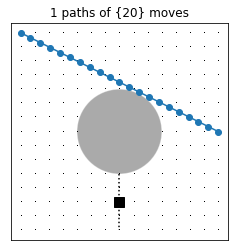

In [17]:
# Waypoints on a line segment that are checked to see if they are outside the circle
p, q = Point(-7, 7), Point(7, 0)
plot([waypoints(p, q)])
assert not intersects_circle(p, q)

Here's a visualization for `expand(frontier)` showing the first six expansions.
Note that the growth in number of paths is much slower then O(9<sup><i>n</i></sup>). After 6 moves there are only 1,107 paths, or just 0.2% of 9<sup>6</sup> = 531,441.

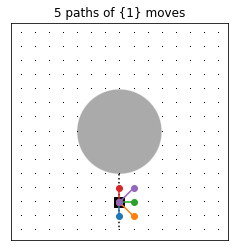

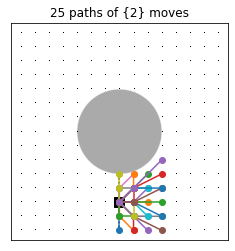

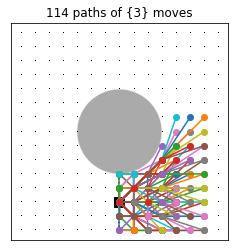

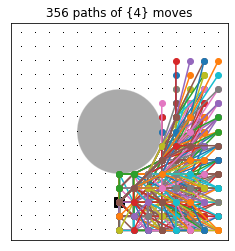

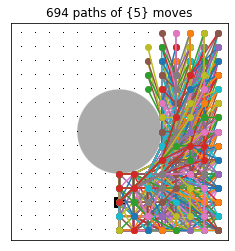

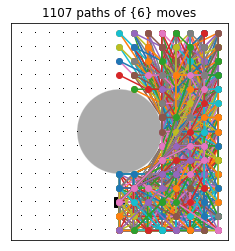

In [18]:
frontier = {(track.start, zero): [track.start]}

for i in range(6):
    frontier = expand(frontier)
    plot(frontier.values())

# A Different Track

Although the code here is not ready to handle large, arbitrary-shaped tracks, it can handle some small variations as is, and other variations with some tweaking. Here I define `track2` to be a track with a larger central circle, and a circular ring of valid points around the circle rather than a full rectangular grid:

[[6, 6, 3, 1, 1, 2, 4, 7, 4, 7, 7, 8, 9, 9, 9, 9, 5, 3, 6, 3, 3],
 [6, 6, 3, 1, 1, 2, 4, 7, 4, 7, 7, 8, 9, 9, 9, 9, 5, 3, 3, 6, 6],
 [6, 6, 3, 1, 1, 2, 4, 7, 4, 7, 7, 8, 9, 9, 9, 9, 5, 3, 3, 6, 3]]

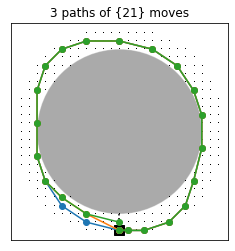

In [19]:
radius2 = 10
track2 = Track({Point(x, y) for x in range(-14, 15) for y in range(-14, 15) 
                if radius2 <= abs(Point(x, y)) < 13}, 
               start=Point(0, -12), 
               finish=[Point(0, -radius2), Point(0, -12)], 
               radius=radius2)

solutions2 = search(track2)
    
plot(solutions2, track=track2)

[digits_from_path(path) for path in solutions2]

# Additional tests:

In [20]:
path1 = [track.start, Point(1, -4)] # First move

assert track.start == Point(0, -5) == 0-5j
assert X(track.start) == 0 and Y(track.start) == -5 
assert velocity([track.start]) == 0
assert velocity(path1) == Vector(1, 1)
assert XY(path1) == ([0, 1], [-5, -4])

assert quadrant(track.start) == 4
assert quadrant(Point(1, 2)) == 1
assert quadrant(Point(-5, 4)) == 2
assert quadrant(Point(-1, -1)) == 3

assert waypoints(0, 10, 10) == [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
assert waypoints(zero, Point(10, 20), 10) == [
    0j,1+2j,2+4j,3+6j,4+8j,5+10j,6+12j,7+14j,8+16j,9+18j,10+20j]

# There are 9 moves from the start point
assert all_moves([track.start]) == {
    -1-4j, -1-5j,  -1-6j, 
     0-4j,  0-5j,   0-6j, 
     1-4j,  1-5j,   1-6j}

# But 3 moves are backwards and 1 stays in the same place; those are disallowed
assert circular_track_moves([track.start]) == {0-6j, 1-6j, 1-5j, 0-4j, 1-4j}
assert expand({(track.start, zero): [track.start]}) == {
 (0-6j, 0-1j): [0-5j, 0-6j],
 (1-6j, 1-1j): [0-5j, 1-6j],
 (1-5j, 1+0j): [0-5j, 1-5j],
 (0-4j, 0+1j): [0-5j, 0-4j],
 (1-4j, 1+1j): [0-5j, 1-4j]}

for path in solutions:
    digits = digits_from_path(path)
    assert path   == path_from_digits(digits_from_path(path))   # Inverses
    assert digits == digits_from_path(path_from_digits(digits)) # Inverses

'tests pass'

'tests pass'